In [ ]:
%%bash 
pip3 install dask[complete] toolz cloudpickle
pip3 install matplotlib
pip3 install statsmodels

In [261]:
from __future__ import division
from scipy.stats import linregress
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import dask.dataframe as dd
import pandas as pd
import numpy as np
import math
import time
import glob

In [262]:
def findSameGeoLocatedCTs(CT_pos):
    ids = list(CT_pos.index.unique())
    id_series = CT_pos.index.unique()
    # The CTs which have the same geo-location.
    result = CT_pos[CT_pos.duplicated(["Latitude","Longitude"], keep=False)].sort_values("Latitude")
    return result, ids

In [263]:
def findMissingCTs(CDR_Data):
    present_ids = np.unique(CDR_Data[["Outgoing", "Terminating"]].values)
    result = set(ids) - set(present_ids)
    return result

In [264]:
def computeUndirectedWeights(dataframe):
    a = dataframe.copy()
    b = dataframe.copy()

    c = pd.merge(a, b, left_on=['Terminating','Outgoing'], right_on=['Outgoing', 'Terminating'], how='left')
    c = c.fillna(0)
    c['Weight'] = 0

    # If outgoing != incoming then weight = call_a + call_b, else use call_a only.
    c['Weight'] = (c['Num_Calls_x'] + c['Num_Calls_y']).where(c['Outgoing_x'] != c['Terminating_x'], c['Num_Calls_x'])
        
    c.drop(['Outgoing_y', 'Terminating_y'], axis=1, inplace=True)
    c = c.rename(columns={'Outgoing_x': 'Outgoing', 'Terminating_x': 'Terminating', 'Num_Calls_x': 'Num_Calls'})
    c.index.name = 'Index'
    
    return c
    
def preprocessCDRData(CDR_Data):
    keep_columns = ['Outgoing', 'Terminating', 'Num_Calls']
    CDR_Data = CDR_Data[keep_columns]
    
    # Remove any row that has an unknown CT.
    known_outgoing = CDR_Data['Outgoing'] >= 0
    known_terminating = CDR_Data['Terminating'] >= 0
    CDR_Data = CDR_Data[known_outgoing & known_terminating]

    # Initial Grouping to get all existing CT pairs.
    grouped_1 = CDR_Data.groupby(by=['Outgoing', 'Terminating'])
    print("group 1")
    
    # Sum up Total Number of Calls per (Outgoing, Terminating) pair. 
    all_pairs = grouped_1.sum().compute()
    all_pairs.reset_index(inplace=True)
    all_pairs.index.names = ['Index']
    print("Total number of calls between CT pairs\n")
    print(all_pairs.head())
    print()

    # Compute undirected weight of (Outgoing, Terminating) pair.
    bidirectional = computeUndirectedWeights(all_pairs)
    bidirectional.reset_index(inplace=True)
    print("Bidirectional CT Pairs")
    print(bidirectional.head())
    print()
    
    # Group by Outgoing CT.
    CT_grouping = bidirectional.groupby('Outgoing')
    
    # Total Activity for each CT.     
    total_activity = CT_grouping.sum()
    total_activity.reset_index(inplace=True)
    total_activity.set_index('Outgoing', inplace=True)
    total_activity= total_activity.rename(columns={'Weight': 'Total_Weight'}) 
    keep_columns=['Total_Weight']
    total_activity =  total_activity[keep_columns]
    
    print("CTs with total activity")
    print(total_activity.head())
    print()
    
    return bidirectional, CT_grouping, total_activity

In [265]:
# METRIC 1: Activity.
def computeActivity(voronoi_data, CT_activity, region_name, scale):
    regional_activity = pd.DataFrame(columns=['Region', 'Activity'])
    regional_activity['Region'] = list(voronoi_data[region_name].unique())
    regional_activity.set_index('Region', inplace=True)
    regional_activity['Activity'] = 0
    regional_activity.sort_index(ascending=True, inplace=True)
    
    indices = CT_activity.index
        
    for index, row in voronoi_data.iterrows():
        ct = row['CT']
        region = row[region_name]
        proportion = row['P_Area_km2'] / row['O_Area_km2']

        if(ct in indices):
            prev_value = regional_activity.loc[region, 'Activity']
            ct_weight = CT_activity.loc[ct, 'Total_Weight'] * scale
            regional_activity.loc[region, 'Activity'] = (proportion * ct_weight) + prev_value
    
    return regional_activity

In [266]:
# METRIC 2: Network Advantage.
def extractKMedian(ct_activity, grouping):
    ct_activity['kmedian'] = 0
    ct_activity['k_degree'] = 0
    ct_activity['k_sum'] = 0
    
    for name, group in grouping:
        weights = sorted(list(group['Weight']))
        
        mid = int(len(weights) / 2)
        k_mid = weights[mid]
        ct_activity.loc[name, 'kmedian'] = k_mid
        
        k_deg = sum(1 for _ in weights if _ > k_mid)
        ct_activity.loc[name, 'k_degree'] = k_deg
        
        k_sum = sum(x for x in weights if x > k_mid)
        ct_activity.loc[name, 'k_sum'] = k_sum

def computeNormalisedEntropy(ct_activity, grouping, ct_pairs, voronoi_data, region_data, region_name):
    # Merge CT total activity with pairs to give CT totals & K Medians for purpose of calculating the fractions.    
    merged = pd.merge(ct_pairs, ct_activity, left_on = 'Outgoing', right_index=True)
    keep_columns = ['Index', 'Outgoing', 'Terminating', 'Weight', 'Total_Weight']
    merged =  merged[keep_columns]
    merged.set_index('Index', inplace=True)
    
    # Calculate fraction * log(fraction) per CT pair.     
    fraction = merged['Weight'] / merged['Total_Weight']
    natural_log_fraction = np.log(fraction)
    merged['Fraction_Product'] = fraction * natural_log_fraction

    # Get total of fraction * log(fraction) for each CT. [CT, Sum_Fraction_Product].   
    sum_fraction_product = merged.groupby('Outgoing').sum()
    keep_columns = ['Fraction_Product']
    sum_fraction_product = sum_fraction_product[keep_columns]

    # Merge ct_activity with fraction_product. Add entropy column = sum_fraction_product / log(k_degree).  
    ct_activity = pd.merge(ct_activity, sum_fraction_product, how='left', left_index=True, right_index=True)    
    ct_activity['ct_entropy'] = (-1 * ct_activity['Fraction_Product']) / np.log(ct_activity['k_degree'])
    
    indices = ct_activity.index
    
    region_entropy = region_data.copy()
    region_entropy['entropy'] = 0
    
    for index, row in voronoi_data.iterrows():
        ct = row['CT']
        region = row[region_name]
        proportion = row['P_Area_km2'] / row['O_Area_km2']

        if(ct in indices):
            prev_value = region_entropy.loc[region, 'entropy']
            new_value = ct_activity.loc[ct, 'ct_entropy']
            region_entropy.loc[region, 'entropy'] = (proportion * new_value) + prev_value
    
    # Normalise entropy by the number of CTs in the region.
    region_entropy['normalised_entropy'] = region_entropy['entropy'] / region_entropy['NUMPOINTS']
    keep_columns = ['normalised_entropy']
    region_entropy = region_entropy[keep_columns]
    region_entropy = region_entropy[np.isfinite(region_entropy['normalised_entropy'])]

    return region_entropy

def computeMedianDegree(ct_activity, ct_pairs, voronoi_data, region_data, region_name, scale):
    # Use total_activity to compute regional_activity.   
    total_activity = ct_activity.copy()
    keep_columns = ['k_sum']
    total_activity = total_activity[keep_columns]
    total_activity.rename(columns={'k_sum' : 'Total_Weight'}, inplace=True)
    
    regional_activity = computeActivity(voronoi_data, total_activity, region_name, scale)
    
    # Merge with region_data to get number of CTs in each region.    
    regional_activity = pd.merge(regional_activity, region_data, left_index=True, right_index=True)
    regional_activity['medDegree'] = regional_activity['Activity'] / regional_activity['NUMPOINTS']
    keep_columns = ['medDegree']
    regional_activity = regional_activity[keep_columns]
    regional_activity = regional_activity[np.isfinite(regional_activity['medDegree'])]

    return regional_activity

In [267]:
# METRIC 3: Introversion.

def computeIntroversion(ct_activity, ct_pairs, voronoi_data, region_data, region_name):
    ct_data = ct_pairs.copy()
    
    keep_columns = ['Outgoing', 'Terminating', 'Weight']
    ct_data = ct_data[keep_columns]
    ct_data['Inner_Traffic'] = (ct_data['Weight']).where(ct_data['Outgoing'] == ct_data['Terminating'], 0)
    
    ct_data = ct_data.groupby('Outgoing').sum()
    keep_columns = ['Weight', 'Inner_Traffic']
    ct_data = ct_data[keep_columns]
    
    ct_data['Outer_Traffic'] = ct_data['Weight'] - ct_data['Inner_Traffic']
    ct_data['Introversion'] = ct_data['Inner_Traffic'] / ct_data['Outer_Traffic']
    
    indices = ct_activity.index
    
    region_introversion = region_data.copy()
    region_introversion['Introversion'] = 0
    
    for index, row in voronoi_data.iterrows():
        ct = row['CT']
        region = row[region_name]  
        proportion = row['P_Area_km2'] / row['O_Area_km2']
        

        if(ct in indices):
            prev_value = region_introversion.loc[region, 'Introversion']
            new_value = ct_data.loc[ct, 'Introversion']
            region_introversion.loc[region, 'Introversion'] = (proportion * new_value) + prev_value
    
    region_introversion['avg_introversion'] = region_introversion['Introversion'] / region_introversion['NUMPOINTS']
    keep_columns = ['avg_introversion']
    region_introversion = region_introversion[keep_columns]
    region_introversion = region_introversion[np.isfinite(region_introversion['avg_introversion'])]
        
    return region_introversion

In [268]:
# METRIC 4. GRAVITY RESIDUAL STARTING WITH REGION FLOWS.
def determine_g(data, column_name):
    x = data['estimated_flow']
    y = data[column_name]
    plt.xlabel('Estimated Flow')
    plt.ylabel('Actual Flow')
    plt.scatter(data['estimated_flow'], data[column_name],color='b',marker='d')
    
    m, b = fit_line(x, y)
    N = 100
    points = np.linspace(x.min(), x.max(), N)
    plt.plot(points, m*points + b)
    print("x-axis: Estimated Flow Pair y-axis: Actual Flow")
    plt.show()
    return m

def fit_line(x, y):
    clean_data = pd.concat([x, y], 1).dropna(0) 
    (_, x), (_, y) = clean_data.iteritems()
    slope, intercept, r, p, stderr = linregress(x, y)
    return slope, intercept 

def determineCTLocation(voronoi_data, region_name):
    vor_data = voronoi_data.copy()
    vor_data = vor_data.sort_values(['CT','P_Area_km2'],ascending=False).groupby('CT').head(1)
    vor_data.set_index('CT', inplace=True)
    vor_data.sort_index(inplace=True)
    keep_columns = [region_name]
    vor_data = vor_data[keep_columns]
    return vor_data

def combineRegionInformation(ct_to_region, ct_pairs, region_name):
    ct_data = ct_pairs.copy()
    ct_data.reset_index(inplace=True)
    keep_columns = ['Outgoing', 'Terminating', 'Weight']
    ct_data = ct_data[keep_columns]
    
    # Add Outgoing CT's region.     
    ct_data = pd.merge(ct_data, ct_to_region, left_on='Outgoing', right_index=True)
    ct_data.rename(columns={region_name : 'Out_region'}, inplace=True)
    
    # Add Terminating CT's region.     
    ct_data = pd.merge(ct_data, ct_to_region, left_on='Terminating', right_index=True)
    ct_data.rename(columns={region_name : 'Term_region'}, inplace=True)
    ct_data.sort_index(inplace=True)
    
    return ct_data

def addRegionInformation(region_data, population_data, geo_locations, region_name):
    region_data = pd.merge(region_data, population_data, left_on="Out_region", right_index=True)
    region_data.rename(columns={'Population' : 'Out_Pop'}, inplace=True)
    
    region_data = pd.merge(region_data, population_data, left_on="Term_region", right_index=True)
    region_data.rename(columns={'Population' : 'Term_Pop'}, inplace=True)
    
    region_data = pd.merge(region_data, geo_locations, left_on="Out_region", right_index=True)
    region_data.rename(columns={'Latitude' : 'Out_Lat', 'Longitude' : 'Out_Lng'}, inplace=True)
    
    region_data = pd.merge(region_data, geo_locations, left_on="Term_region", right_index=True)
    region_data.rename(columns={'Latitude' : 'Term_Lat', 'Longitude' : 'Term_Lng'}, inplace=True)
    
    return region_data
        
def computeGravityResidualRegion(ct_pairs, voronoi_data, population_data, geo_locations, activity, region_name):
    ct_to_region = determineCTLocation(voronoi_data, region_name)
    ct_data = combineRegionInformation(ct_to_region, ct_pairs, region_name)
    
    region_data = ct_data.groupby(['Out_region', 'Term_region']).sum()
    region_data.reset_index(inplace=True)
    keep_columns = ['Out_region', 'Term_region', 'Weight']
    region_data = region_data[keep_columns]
    
    region_data = addRegionInformation(region_data, population_data, geo_locations, region_name)
    
    #  Computing the estimated flow.   
    population_product = region_data['Out_Pop'] * region_data['Term_Pop']
    distance = np.vectorize(calculate_distance)(region_data['Out_Lat'], region_data['Out_Lng'], region_data['Term_Lat'], region_data['Term_Lng'])
    distance = distance ** 2
    region_data['estimated_flow'] = population_product / distance
    region_data = region_data.replace(np.inf, np.nan)

    region_data = region_data[np.isfinite(region_data['estimated_flow'])]
    region_data.sort_index(ascending=True, inplace=True)
    keep_columns = ['Out_region', 'Term_region', 'Weight', 'estimated_flow']
    region_data = region_data[keep_columns]
    
    print("x-axis: Index of Region Pair y-axis: Estimated Flow")
    plt.scatter(region_data.index, region_data['estimated_flow'],color='b')
    plt.show()
    
    print("x-axis: Index of Region Pair y-axis: Actual Flow")
    plt.scatter(region_data.index, region_data['Weight'],color='b')
    plt.show()

    g = determine_g(region_data, 'Weight')
    print(g)
    
    region_data['estimated_flow'] = g * region_data['estimated_flow']    
    region_data['negRes'] = (region_data['Weight'] - region_data['estimated_flow']).where(region_data['Weight'] < region_data['estimated_flow'], 0)
    region_data['ones'] = 1
    region_data['n_negRes'] = (region_data['ones']).where(region_data['negRes'] < 0, 0)
    
    #  Computing the gravity residual for each Region.
    region_data = region_data.groupby('Out_region')
    region_data = region_data.sum()
    region_data['gResidual'] = region_data['negRes'] / region_data['n_negRes']
    keep_columns = ['negRes', 'n_negRes', 'gResidual']
    region_data = region_data[keep_columns]
    region_data= region_data.rename(columns={'Out_region': 'Region'})
    print(region_data.head())
    return region_data

In [269]:
# Cote D'Ivoire Files.
directory = "CDR_Data_IC/SET1TSV/"
ant_pos_loc = "CDR_Data_IC/"
all_CDR_files = "CDR_Data_IC/SET1TSV/*.TSV"
pop_path = "CDR_Data_IC/Region_Population/"
centroid_path  = "CDR_Data_IC/region_centroids/"
vor_path = "CDR_Data_IC/Voronoi_Polygons/Proportions/"
points_in_polygon = "CDR_Data_IC/Points_In_Polygon/"

# Retrieve required files for Cote D'Ivoire.
complete_cdr_data = dd.read_csv(all_CDR_files, delim_whitespace=True, header=None, 
                       names=['Date', 'Time', 'Outgoing', 'Terminating', 'Num_Calls', 'Total_Duration'],
                       usecols=['Outgoing', 'Terminating', 'Num_Calls'])

# allFiles = glob.glob(directory + "/*.TSV")
# frame = pd.DataFrame()
# list_ = []
# count = 1
# for file_ in allFiles:
#     print("before")
#     df = pd.read_csv(file_,index_col=None, header=0)
#     list_.append(df)
#     print(count)
#     count = count + 1
# frame = pd.concat(list_)

antenna_positions = pd.read_csv(ant_pos_loc + "ANT_POS.TSV", delim_whitespace=True, header=None, 
                                names = ["CT", "Latitude", "Longitude"], index_col="CT")

antenna_info = pd.read_csv(ant_pos_loc + "CT_info.csv", index_col="CT")

voronoi_admin_1 = pd.read_csv(vor_path + "voronoi_admin_1.csv", 
                              usecols=["CT", "O_Area_km2", "ID_1", "P_Area_km2"])

voronoi_admin_2 = pd.read_csv(vor_path + "voronoi_admin_2.csv", 
                              usecols=["CT", "O_Area_km2", "ID_2", "P_Area_km2"])

voronoi_admin_3 = pd.read_csv(vor_path + "voronoi_admin_3.csv", 
                              usecols=["CT", "O_Area_km2", "ID_3", "P_Area_km2"])

pip_admin_1 = pd.read_csv(points_in_polygon + "PIP_Admin_1.csv", usecols=["ID_1", "NUMPOINTS"], index_col="ID_1")
pip_admin_1.index.names = ['Region']
pip_admin_1.sort_index(ascending=True, inplace=True)

pip_admin_2 = pd.read_csv(points_in_polygon + "PIP_Admin_2.csv", usecols=["ID_2", "NUMPOINTS"], index_col="ID_2")
pip_admin_2.index.names = ['Region']
pip_admin_2.sort_index(ascending=True, inplace=True)

pip_admin_3 = pd.read_csv(points_in_polygon + "PIP_Admin_3.csv", usecols=["ID_3", "NUMPOINTS"], index_col="ID_3")
pip_admin_3.index.names = ['Region']
pip_admin_3.sort_index(ascending=True, inplace=True)

admin_1_centroids = pd.read_csv(centroid_path + "centroids_admin_1.csv", index_col="ID_1")
admin_2_centroids = pd.read_csv(centroid_path + "centroids_admin_2.csv", index_col="ID_2")
admin_3_centroids = pd.read_csv(centroid_path + "centroids_admin_3.csv", index_col="ID_3")

admin_1_pop = pd.read_csv(pop_path + "admin_1_pop.csv", index_col="ID_1")
admin_2_pop = pd.read_csv(pop_path + "admin_2_pop.csv", index_col="ID_2")
admin_3_pop = pd.read_csv(pop_path + "admin_3_pop.csv", index_col="ID_3")

group 1
Total number of calls between CT pairs

       Outgoing  Terminating  Num_Calls
Index                                  
0             1            1      90981
1             1            4        116
2             1            5        459
3             1            9        677
4             1           10        353

Bidirectional CT Pairs
   Index  Outgoing  Terminating  Num_Calls  Num_Calls_y   Weight
0      0         1            1      90981      90981.0  90981.0
1      1         1            4        116        130.0    246.0
2      2         1            5        459        356.0    815.0
3      3         1            9        677        816.0   1493.0
4      4         1           10        353        434.0    787.0

CTs with total activity
          Total_Weight
Outgoing              
1             707770.0
2             159785.0
3             174330.0
4             238144.0
5            3084195.0

x-axis: Index of Region Pair y-axis: Estimated Flow


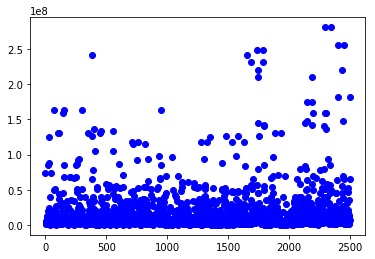

x-axis: Index of Region Pair y-axis: Actual Flow


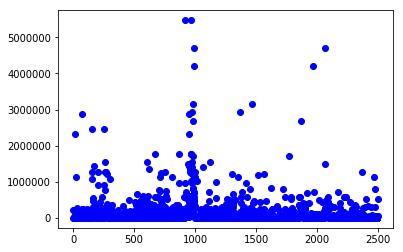

x-axis: Estimated Flow Pair y-axis: Actual Flow


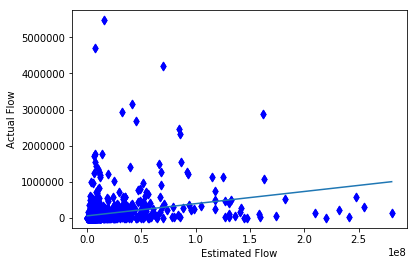

0.00336843874499
                  negRes  n_negRes     gResidual
Out_region                                      
1          -3.317199e+05        25 -13268.797737
2          -1.877658e+05        21  -8941.226868
3          -2.115740e+06        41 -51603.403371
4          -2.061872e+04         5  -4123.744884
5          -1.558014e+05        20  -7790.071457


In [273]:
# Cote D'Ivoire Processing

# 1. Find CTs which have the same latitude and longitude.
same_geo, ids = findSameGeoLocatedCTs(antenna_positions)
print(same_geo)

# 2. Find the CTs missing from the CDR Data.
missing_data = findMissingCTs(complete_cdr_data)
print(missing_data)

s = time.time()
# 3. Process CDR Data to get activity of all CT pairs and activity of each CT.
bidirectional_CT, CT_groups, total_CT_activity = preprocessCDRData(complete_cdr_data)

# 4. Compute Activity of each Region.
regional_activity_1 = computeActivity(voronoi_admin_1, total_CT_activity, "ID_1", 1)
regional_activity_2 = computeActivity(voronoi_admin_2, total_CT_activity, "ID_2", 1)
regional_activity_3 = computeActivity(voronoi_admin_3, total_CT_activity, "ID_3", 1)

regional_activity_1.to_csv("CDR_Data_IC/Activity/activity_admin_1.csv", index=True)
regional_activity_2.to_csv("CDR_Data_IC/Activity/activity_admin_2.csv", index=True)
regional_activity_3.to_csv("CDR_Data_IC/Activity/activity_admin_3.csv", index=True)
print(regional_activity_1)

# 5. Compute Normalised Entropy and Median Degree.
extractKMedian(total_CT_activity, CT_groups)

# Normalised Entropy
norm_entropy_1 = computeNormalisedEntropy(total_CT_activity, CT_groups, bidirectional_CT, voronoi_admin_1, pip_admin_1, "ID_1")
norm_entropy_2 = computeNormalisedEntropy(total_CT_activity, CT_groups, bidirectional_CT, voronoi_admin_2, pip_admin_2, "ID_2")
norm_entropy_3 = computeNormalisedEntropy(total_CT_activity, CT_groups, bidirectional_CT, voronoi_admin_3, pip_admin_3, "ID_3")
norm_entropy_1.to_csv("CDR_Data_IC/Network_Advantage/entropy_admin_1.csv", index=True)
norm_entropy_2.to_csv("CDR_Data_IC/Network_Advantage/entropy_admin_2.csv", index=True)
norm_entropy_3.to_csv("CDR_Data_IC/Network_Advantage/entropy_admin_3.csv", index=True)
print(norm_entropy_1)

# Median Degree.
medDegree_1 = computeMedianDegree(total_CT_activity, bidirectional_CT, voronoi_admin_1, pip_admin_1, "ID_1", 1)
medDegree_2 = computeMedianDegree(total_CT_activity, bidirectional_CT, voronoi_admin_2, pip_admin_2, "ID_2", 1)
medDegree_3 = computeMedianDegree(total_CT_activity, bidirectional_CT, voronoi_admin_3, pip_admin_3, "ID_3", 1)
medDegree_1.to_csv("CDR_Data_IC/Network_Advantage/meddegree_admin_1.csv", index=True)
medDegree_2.to_csv("CDR_Data_IC/Network_Advantage/meddegree_admin_2.csv", index=True)
medDegree_3.to_csv("CDR_Data_IC/Network_Advantage/meddegree_admin_3.csv", index=True)
print(medDegree_1)

# 6. Compute Introversion.
introversion_1 = computeIntroversion(total_CT_activity, bidirectional_CT, voronoi_admin_1, pip_admin_1, "ID_1")
introversion_2 = computeIntroversion(total_CT_activity, bidirectional_CT, voronoi_admin_2, pip_admin_2, "ID_2")
introversion_3 = computeIntroversion(total_CT_activity, bidirectional_CT, voronoi_admin_3, pip_admin_3, "ID_3")
introversion_1.to_csv("CDR_Data_IC/Introversion/introversion_admin_1.csv", index=True)
introversion_2.to_csv("CDR_Data_IC/Introversion/introversion_admin_2.csv", index=True)
introversion_3.to_csv("CDR_Data_IC/Introversion/introversion_admin_3.csv", index=True)

# 7. Compute Gravity Residual using Regions.
gresidual_1 = computeGravityResidualRegion(bidirectional_CT, voronoi_admin_1, admin_1_pop, admin_1_centroids, regional_activity_1,'ID_1')
gresidual_2 = computeGravityResidualRegion(bidirectional_CT, voronoi_admin_2, admin_2_pop, admin_2_centroids, regional_activity_2,'ID_2')
gresidual_3 = computeGravityResidualRegion(bidirectional_CT, voronoi_admin_3, admin_3_pop, admin_3_centroids, regional_activity_3,'ID_3')
gresidual_1.to_csv("CDR_Data_IC/Gravity_Residual/gresidual_admin_1.csv", index=True)
gresidual_2.to_csv("CDR_Data_IC/Gravity_Residual/gresidual_admin_2.csv", index=True)
gresidual_3.to_csv("CDR_Data_IC/Gravity_Residual/gresidual_admin_3.csv", index=True)

x-axis: Index of Region Pair y-axis: Estimated Flow


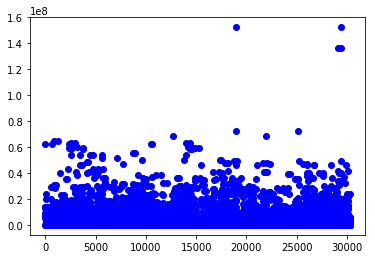

x-axis: Index of Region Pair y-axis: Actual Flow


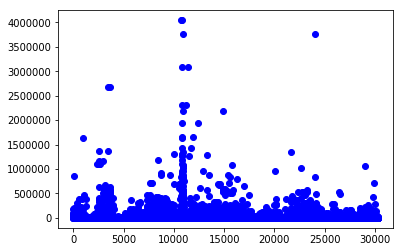

x-axis: Estimated Flow Pair y-axis: Actual Flow


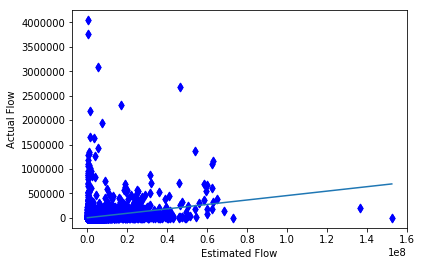

0.0045348891764
                   negRes  n_negRes    gResidual
Out_region                                      
1          -529490.280491       126 -4202.303813
2          -368309.765441       155 -2376.192035
3          -206977.229207       129 -1604.474645
4          -276426.363796       129 -2142.840029
5          -393664.871402       146 -2696.334736


In [274]:
gresidual_3 = computeGravityResidualRegion(bidirectional_CT, voronoi_admin_3, admin_3_pop, admin_3_centroids, regional_activity_3,'ID_3')

In [ ]:
# Senegal Files.
directory = "CDR_Data_Sen/SET1/"
ant_pos_loc = "CDR_Data_Sen/"
all_CDR_files = "CDR_Data_Sen/SET1/*.CSV"
pop_path = "CDR_Data_Sen/Region_Population/"
centroid_path  = "CDR_Data_Sen/region_centroids/"
vor_path = "CDR_Data_Sen/Voronoi_Polygons/Proportions/"
points_in_polygon = "CDR_Data_Sen/Points_In_Polygon/"

# Retrieve required files for Cote D'Ivoire.
complete_cdr_data = dd.read_csv(all_CDR_files, header=None, names=['Date', 'Outgoing', 'Terminating', 'Num_Calls', 'Total_Duration'],
                       usecols=['Outgoing', 'Terminating', 'Num_Calls'])

antenna_positions = pd.read_csv(ant_pos_loc + "SITE_LONLAT.csv", header=0, 
                                names=["CT", "Longitude", "Latitude"], index_col="CT")

voronoi_admin_1 = pd.read_csv(vor_path + "voronoi_admin_1.csv", usecols=["CT", "O_Area_km2", "ID_1", "P_Area_km2"])

voronoi_admin_2 = pd.read_csv(vor_path + "voronoi_admin_2.csv", usecols=["CT", "O_Area_km2", "ID_2", "P_Area_km2"])

voronoi_admin_3 = pd.read_csv(vor_path + "voronoi_admin_3.csv", usecols=["CT", "O_Area_km2", "ID_3", "P_Area_km2"])

pip_admin_1 = pd.read_csv(points_in_polygon + "PIP_Admin_1.csv", usecols=["ID_1", "NUMPOINTS"], index_col="ID_1")
pip_admin_1.index.names = ['Region']
pip_admin_1.sort_index(ascending=True, inplace=True)

pip_admin_2 = pd.read_csv(points_in_polygon + "PIP_Admin_2.csv", usecols=["ID_2", "NUMPOINTS"], index_col="ID_2")
pip_admin_2.index.names = ['Region']
pip_admin_2.sort_index(ascending=True, inplace=True)

pip_admin_3 = pd.read_csv(points_in_polygon + "PIP_Admin_3.csv", usecols=["ID_3", "NUMPOINTS"], index_col="ID_3")
pip_admin_3.index.names = ['Region']
pip_admin_3.sort_index(ascending=True, inplace=True)

admin_1_centroids = pd.read_csv(centroid_path + "centroids_admin_1.csv", index_col="ID_1")
admin_2_centroids = pd.read_csv(centroid_path + "centroids_admin_2.csv", index_col="ID_2")
admin_3_centroids = pd.read_csv(centroid_path + "centroids_admin_3.csv", index_col="ID_3")

admin_1_pop = pd.read_csv(pop_path + "admin_1_pop.csv", index_col="ID_1")
admin_2_pop = pd.read_csv(pop_path + "admin_2_pop.csv", index_col="ID_2")
admin_3_pop = pd.read_csv(pop_path + "admin_3_pop.csv", index_col="ID_3")


In [ ]:
# Senegal Processing.
# 1. Find CTs which have the same latitude and longitude.
same_geo, ids = findSameGeoLocatedCTs(antenna_positions)
print(same_geo)

# 2. Find the CTs missing from the CDR Data.
s = time.time()
missing_data = findMissingCTs(complete_cdr_data)
e = time.time()
print(e - s)
print(missing_data)

# 3. Process CDR Data to get activity of all CT pairs and activity of each CT.
s = time.time()
bidirectional_CT, CT_groups, total_CT_activity = preprocessCDRData(complete_cdr_data)
e = time.time()
print(e - s)

# 4. Compute Activity of each Region.
s = time.time()
regional_activity_1 = computeActivity(voronoi_admin_1, total_CT_activity, "ID_1", 1)
regional_activity_2 = computeActivity(voronoi_admin_2, total_CT_activity, "ID_2", 1)
regional_activity_3 = computeActivity(voronoi_admin_3, total_CT_activity, "ID_3", 1)

regional_activity_1.to_csv("CDR_Data_Sen/Activity/activity_admin_1.csv", index=True)
regional_activity_2.to_csv("CDR_Data_Sen/Activity/activity_admin_2.csv", index=True)
regional_activity_3.to_csv("CDR_Data_Sen/Activity/activity_admin_3.csv", index=True)
e = time.time()
print(e - s)
print(regional_activity_1)

# 5. Compute Normalised Entropy and Median Degree.
s = time.time()
extractKMedian(total_CT_activity, CT_groups)

# Normalised Entropy
norm_entropy_1 = computeNormalisedEntropy(total_CT_activity, CT_groups, bidirectional_CT, voronoi_admin_1, pip_admin_1, "ID_1")
norm_entropy_2 = computeNormalisedEntropy(total_CT_activity, CT_groups, bidirectional_CT, voronoi_admin_2, pip_admin_2, "ID_2")
norm_entropy_3 = computeNormalisedEntropy(total_CT_activity, CT_groups, bidirectional_CT, voronoi_admin_3, pip_admin_3, "ID_3")
norm_entropy_1.to_csv("CDR_Data_Sen/Network_Advantage/entropy_admin_1.csv", index=True)
norm_entropy_2.to_csv("CDR_Data_Sen/Network_Advantage/entropy_admin_2.csv", index=True)
norm_entropy_3.to_csv("CDR_Data_Sen/Network_Advantage/entropy_admin_3.csv", index=True)
print(norm_entropy_1)
e = time.time()
print(e - s)

# Median Degree.
s = time.time()
medDegree_1 = computeMedianDegree(total_CT_activity, bidirectional_CT, voronoi_admin_1, pip_admin_1, "ID_1", 1)
medDegree_2 = computeMedianDegree(total_CT_activity, bidirectional_CT, voronoi_admin_2, pip_admin_2, "ID_2", 1)
medDegree_3 = computeMedianDegree(total_CT_activity, bidirectional_CT, voronoi_admin_3, pip_admin_3, "ID_3", 1)
medDegree_1.to_csv("CDR_Data_Sen/Network_Advantage/meddegree_admin_1.csv", index=True)
medDegree_2.to_csv("CDR_Data_Sen/Network_Advantage/meddegree_admin_2.csv", index=True)
medDegree_3.to_csv("CDR_Data_Sen/Network_Advantage/meddegree_admin_3.csv", index=True)
print(medDegree_1)
e = time.time()
print(e - s)

# 6. Compute Introversion.
s = time.time()
introversion_1 = computeIntroversion(total_CT_activity, bidirectional_CT, voronoi_admin_1, pip_admin_1, "ID_1")
introversion_2 = computeIntroversion(total_CT_activity, bidirectional_CT, voronoi_admin_2, pip_admin_2, "ID_2")
introversion_3 = computeIntroversion(total_CT_activity, bidirectional_CT, voronoi_admin_3, pip_admin_3, "ID_3")
introversion_1.to_csv("CDR_Data_Sen/Introversion/introversion_admin_1.csv", index=True)
introversion_2.to_csv("CDR_Data_Sen/Introversion/introversion_admin_2.csv", index=True)
introversion_3.to_csv("CDR_Data_Sen/Introversion/introversion_admin_3.csv", index=True)
e = time.time()
print(e - s)

# 7. Compute Gravity Residual using Regions.
s = time.time()
gresidual_1 = computeGravityResidualRegion(bidirectional_CT, voronoi_admin_1, admin_1_pop, admin_1_centroids, regional_activity_1,'ID_1')
gresidual_2 = computeGravityResidualRegion(bidirectional_CT, voronoi_admin_2, admin_2_pop, admin_2_centroids, regional_activity_2,'ID_2')
gresidual_3 = computeGravityResidualRegion(bidirectional_CT, voronoi_admin_3, admin_3_pop, admin_3_centroids, regional_activity_3,'ID_3')
gresidual_1.to_csv("CDR_Data_Sen/Gravity_Residual/gresidual_admin_1.csv", index=True)
gresidual_2.to_csv("CDR_Data_Sen/Gravity_Residual/gresidual_admin_2.csv", index=True)
gresidual_3.to_csv("CDR_Data_Sen/Gravity_Residual/gresidual_admin_3.csv", index=True)
e = time.time()
print(e - s)


In [ ]:
# # METRIC 2. GRAVITY RESIDUAL STARTING WITH CT FLOWS.
# # Remember to ignore incoming = outgoing.

# def calculate_distance(lat_a, long_a, lat_b, long_b):
#     earth_radius_km = 6371.0
#     lat1 = math.radians(lat_a)
#     lon1 = math.radians(long_a)
#     lat2 = math.radians(lat_b)
#     lon2 = math.radians(long_b)

#     dlon = lon2 - lon1
#     dlat = lat2 - lat1

#     a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
#     c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
#     distance = earth_radius_km * c
#     return distance

# # Get GeoLocations + Populations for Outgoing & Incoming CTs.
# def combineCTInformation(ct_pairs):
#     ct_data = ct_pairs.copy()
#     ct_data.reset_index(inplace=True)
#     keep_columns = ['Outgoing', 'Terminating', 'Weight']
#     ct_data = ct_data[keep_columns]
    
#     # Join with antenna_info on Outgoing CTs.
#     ct_data = pd.merge(ct_data, antenna_info, left_on='Outgoing', right_index=True)
#     ct_data.rename(columns={'Latitude':'Out_Lat', 'Longitude' : 'Out_Lng', 'Population' : 'Out_Pop'}, inplace=True)
    
#     # Join with antenna_info on Terminating CTs. Note: This distorts usual order but its not an issue.
#     ct_data = pd.merge(ct_data, antenna_info, left_on='Terminating', right_index=True)
#     ct_data.rename(columns={'Latitude':'Term_Lat', 'Longitude' : 'Term_Lng', 'Population' : 'Term_Pop'}, inplace=True)    
    
#     keep_columns = ['Outgoing', 'Terminating', 'Weight', 'Out_Lat', 'Out_Lng', 'Out_Pop', 'Term_Lat', 'Term_Lng', 'Term_Pop']
#     ct_data = ct_data[keep_columns]
#     ct_data.sort_index(inplace=True)  
#     return ct_data

# def determine_g(ct_data):
#     x = ct_data['estimated_flow']
#     y = ct_data['Weight']
#     plt.xlabel('Estimated Flow b/w CTs')
#     plt.ylabel('Actual Flow b/w CTs')
#     plt.scatter(ct_data['estimated_flow'], ct_data['Weight'],color='r',marker='d')
    
#     m, b = fit_line(x, y)
#     N = 100
#     points = np.linspace(x.min(), x.max(), N)
#     plt.plot(points, m*points + b)
#     plt.show()
#     return m

# def fit_line(x, y):
#     clean_data = pd.concat([x, y], 1).dropna(0) 
#     (_, x), (_, y) = clean_data.iteritems()
#     slope, intercept, r, p, stderr = linregress(x, y)
#     return slope, intercept 
    
# def computeGravityResidual(CT_pairs):
#     ct_data = combineCTInformation(CT_pairs)
    
#     #  Computing the estimated flow.   
#     population_product = ct_data['Out_Pop'] * ct_data['Term_Pop']
#     distance = np.vectorize(calculate_distance)(ct_data['Out_Lat'], ct_data['Out_Lng'], ct_data['Term_Lat'], ct_data['Term_Lng'])
#     distance = distance ** 2
#     ct_data['estimated_flow'] = population_product / distance
#     ct_data = ct_data.replace(np.inf, np.nan)

#     g = determine_g(ct_data)
    
#     #  Computing the negRes.       
# #     reduced_ct_data = ct_data.copy()
# #     reduced_ct_data['negRes'] = (reduced_ct_data['Weight'] - (g * reduced_ct_data['estimated_flow'])).where(reduced_ct_data['Weight'] <
# #                                                                                                 reduced_ct_data['estimated_flow'], 0)
    
# #     #  Count the number of negative residuals.
# #     reduced_ct_data['ones'] = 1
# #     reduced_ct_data['n_negRes'] = (reduced_ct_data['ones']).where(reduced_ct_data['negRes'] > 0, 0)
    
# #     #  Computing the gravity residual for each CT.
# #     ct_data_group = reduced_ct_data.groupby('Outgoing')
# #     ct_data_group = ct_data_group.sum()
# #     keep_columns = ['Weight', 'estimated_flow', 'negRes', 'n_negRes']
# #     ct_data_group = ct_data_group[keep_columns]
# #     ct_data_group['gResidual'] = ct_data_group['negRes'] / ct_data_group['n_negRes']
# #     print(ct_data_group)

# computeGravityResidual(bidirectional_CT)

